# CSCI 450 Project 2 | Malek Elaghel
### 12/08/2023

# Particle Physics Collision Image Classification Project

## Overview
In the initial phase of this project, Support Vector Machines (SVM) and Random Forests were employed to classify images of simulated proton–proton LHC collisions at 13 TeV. The dataset comprises three classes:
1. Quantum Chromodynamics (QCD)
2. Top-Antitop Pair Production (TTbar)
3. W Bosons in association with jets (WJets)
Features extracted included **Histogram of Oriented Gradients** (HOG) and **Local Binary Pattern**, along with class statistics.

### Initial Findings
- The models demonstrated an accuracy surpassing random guessing, ranging from 0.46 to 0.48.
- Notably, challenges arose in distinguishing between QCD and WJets, with models tending to mix these classes.
- Principal Component Analysis (PCA) did not significantly enhance accuracy and, in some instances, led to a decrease, suggesting a delicate balance between feature reduction and information loss.
- Linear Binary models exhibited lower accuracy, prompting considerations about the suitability of linear decision boundaries.

## Current Phase: Convolutional Neural Networks (CNN)
In the next phase of the project, Convolutional Neural Networks (CNN) will be employed to further enhance the classification performance. The transition to CNN represents a shift towards leveraging deep learning for image recognition tasks. This approach aims to capture intricate hierarchical features within the images, potentially addressing the challenges observed in the earlier models.


This project presents a holistic approach to particle physics collision image classification.


## Initial Setup and Imports

This block of code initializes the project by importing essential libraries and setting up the TensorFlow environment. Key libraries include TensorFlow for deep learning functionalities, scikit-learn for metrics evaluation, OpenCV for image processing, and Matplotlib for visualizations. The project also employs ResNet50V2 and MobileNetV2 architectures for transfer learning, along with various callback functions and data augmentation techniques.


In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import glob
import os
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## GPU Availability and TensorFlow Version

This code snippet checks the availability of GPUs for accelerated training and prints the number of GPUs available. Additionally, it displays the current version of TensorFlow being used in the project.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  2
2.13.0


## Image Normalization Function

The provided function, `im_normalize`, performs normalization on a grayscale image, ensuring that its pixel values are within the range [0, 1]. This step is crucial for standardizing input data and facilitating more stable and effective training of Convolutional Neural Networks (CNNs).


In [3]:
def im_normalize(image):
    """Normalizes a grayscale image to the range [0, 1]."""
    channel_min = tf.math.reduce_min(image)
    channel_max = tf.math.reduce_max(image)
    if channel_max > channel_min:
        image = (image - channel_min) / (channel_max - channel_min)
    # Avoid division by zero
    else:
        image = tf.zeros_like(image)
    return image

## Image Size and Number of Classes

These variables, `IMG_SIZE` and `NUMCLASSES`, define the desired image size for pre-processing (set to 256) and the number of classes in the particle physics collision image classification task (set to 3: Quantum Chromodynamics, Top-Antitop Pair Production, and W Bosons in association with jets).

In [4]:
IMG_SIZE = 256
NUMCLASSES = 3

## Image Preprocessing Functions

The provided functions, `preprocess_image` and `load_data`, contribute to the image preprocessing pipeline for the particle physics collision image classification task.

### `preprocess_image`:
This function takes a filename and its corresponding label, loads the image as grayscale, resizes it to the specified dimensions, adjusts brightness, normalizes pixel values, and replicates the grayscale channel to create a 3-channel image. This standardized preprocessing ensures consistency in input data for the Convolutional Neural Network (CNN).

### `load_data`:
This function loads filepaths, labels, class names, and class sizes from a specified directory containing image files. It utilizes the glob module to retrieve file paths directly, and the output includes filepaths, labels, class sizes, and class names. This information is crucial for data input and class distribution analysis.


In [5]:
def preprocess_image(filename, label):
    """Loads an image as grayscale, resizes it, adjusts brightness, normalizes it, and replicates channels."""
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_png(image_string, channels=1)  # Set channels to 1 for grayscale
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = im_normalize(image_resized)
    # Replicate the grayscale channel to create a 3-channel image
    image_replicated = tf.repeat(image_normalized, repeats=3, axis=-1)
    return image_replicated, label


In [6]:
def load_data(directory):
    """
    Loads the filepaths, labels, class names, and class sizes from a directory containing image files.

    Parameters:
    directory (str): The directory path containing the image files.

    Returns:
    tuple: A tuple containing the filepaths, labels, class sizes, and class names.

    Example:
    filepaths, labels, class_sizes = load_data("path/to/directory"), class_names
    """
    class_names = np.array(os.listdir(directory))

    # Use glob to get list of files directly
    class_filepaths_list = [glob.glob(os.path.join(directory, class_name, "*.png")) for class_name in class_names]
    filepaths = np.concatenate(class_filepaths_list)
    
    # Initialize arrays
    labels = np.repeat(np.arange(len(class_names)), [len(class_files) for class_files in class_filepaths_list])
    class_sizes = np.array([len(class_files) for class_files in class_filepaths_list], dtype=np.int64)

    return filepaths, labels, class_sizes, class_names

## Data Visualization: Random Image Samples

This code block visualizes random samples from each class (QCD, TTbar, and WJets) in the training and test datasets. The `display_random_samples` function selects random images from the specified directories, preprocesses them using the provided `preprocess_image` function, and displays a grid of subplots.

### Key Components:
- `train_path` and `test_path`: Paths to the training and test datasets.
- `load_data` function: Loads filepaths, labels, class names, and class sizes from the specified directories.
- `preprocess_image` function: Standardizes image preprocessing steps.
- `display_random_samples` function: Visualizes a grid of randomly selected image samples from each class, facilitating a qualitative understanding of the dataset.

This visualization aids in assessing the diversity and characteristics of the images within each class.


In [7]:
train_path = "/kaggle/input/proton-collision-image-set/Proton Collision 13TeV/Train"
test_path = "/kaggle/input/proton-collision-image-set/Proton Collision 13TeV/Test"

In [8]:
# Load data
train_filepaths, train_labels, train_class_sizes, train_class_names = load_data(train_path)
test_filepaths, test_labels, test_class_sizes = load_data(test_path)[:3]

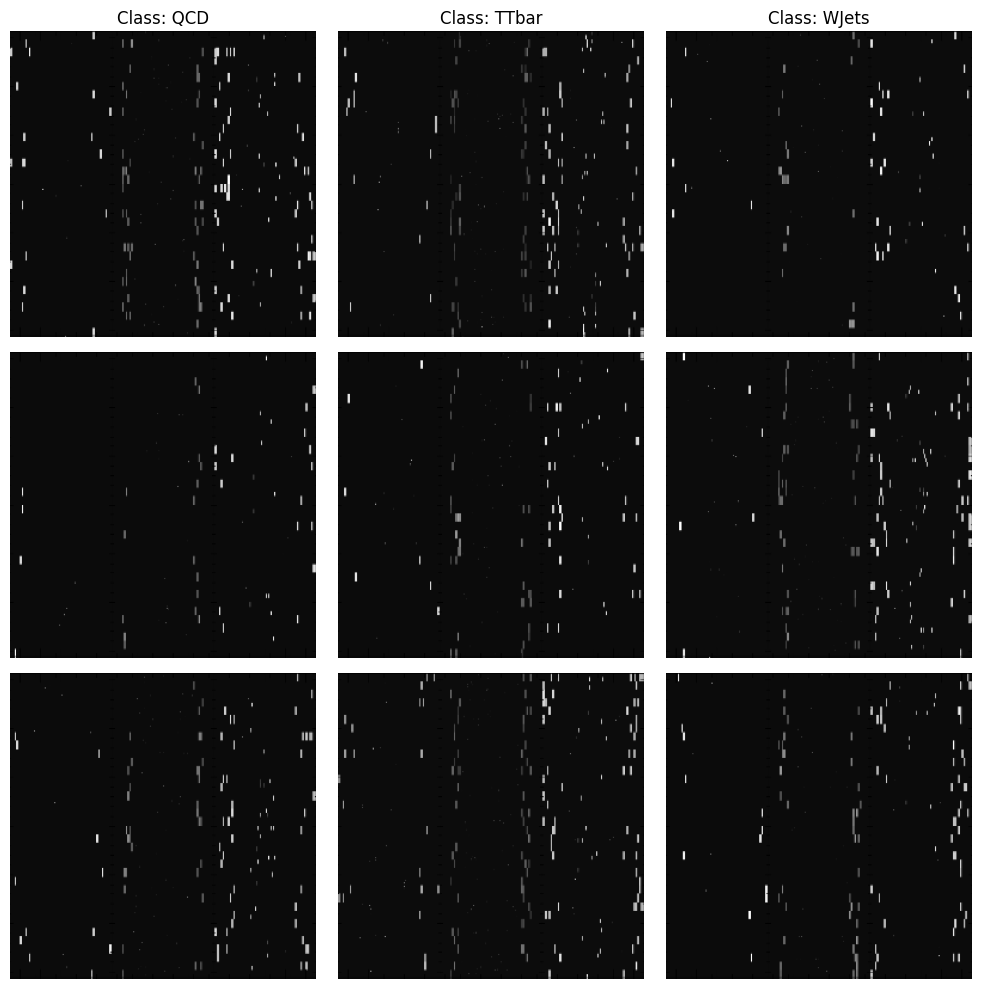

In [9]:
def display_random_samples(class_names, root_directories, preprocess_func, num_samples=3):
    # Calculate the total number of subplots needed
    total_plots = num_samples * len(class_names)
    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, len(class_names), figsize=(10, 10))
    
    for class_idx, class_name in enumerate(class_names):
        # Calculate the directory index based on the number of directories available
        directory_idx = class_idx % len(root_directories)

        # Get filepaths for the current class using glob
        files = glob.glob(os.path.join(root_directories[directory_idx], class_name, "*.png"))
        
        # Ensure there are enough files to sample from
        if len(files) >= num_samples:
            # Select a random subset of files
            sampled_files = random.sample(files, num_samples)

            for i, random_filepath in enumerate(sampled_files):
                # Preprocess the image
                image = preprocess_func(random_filepath, class_idx)[0]

                # Convert to numpy array and squeeze if single-channel
                image = image.numpy().squeeze()

                # Get the corresponding subplot axis
                ax = axes[i, class_idx]
                
                # Plot the image
                ax.imshow(image, cmap='gray')
                ax.axis('off')
                if i % 3 == 0:
                    ax.set_title(f'Class: {class_name}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
root_directories = [train_path, test_path]
display_random_samples(['QCD', 'TTbar', 'WJets'], root_directories, preprocess_image, 3)


In [10]:
train_filepaths.size, train_labels.size

(25314, 25314)

## Data Splitting and Label One-Hot Encoding

In this section, the training dataset is split into training and validation sets using the `train_test_split` function. This step is crucial for assessing the model's performance on data it has not seen during training.

Additionally, the labels are one-hot encoded to transform categorical labels into a binary matrix format. This encoding is necessary for training a neural network, allowing it to effectively learn and differentiate between the distinct classes (QCD, TTbar, WJets).


In [11]:
# Split training data into training and validating sets
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(
    train_filepaths, train_labels, test_size=0.2, random_state=42
)

In [12]:
# One-hot encode your labels if they are not already
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=NUMCLASSES)
val_labels_one_hot = tf.keras.utils.to_categorical(val_labels, num_classes=NUMCLASSES)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=NUMCLASSES)


| Labels | Testing | Training | Validating |
|--------|---------|----------|------------|
| QCD    | 4692    | 6751     | 1688       |
| TTbar  | 4691    | 6744     | 1687       |
| WJets  | 4691    | 6755     | 1689       |


In [13]:
isinstance(train_labels_one_hot, np.ndarray)

True

In [14]:
train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape

((20251, 3), (5063, 3), (14074, 3))

In [15]:
test_filepaths.size, test_labels.size

(14074, 14074)

In [16]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))
sum(counts)

{0: 6711, 1: 6779, 2: 6761}


20251

## TensorFlow Datasets Creation

The code block converts the arrays representing filepaths and one-hot encoded labels into TensorFlow datasets using `tf.data.Dataset.from_tensor_slices`. This conversion is necessary for efficient data handling and input to the neural network during training and validation.

### Key Components:
- `train_dataset_one_hot`: TensorFlow dataset for training with one-hot encoded labels.
- `val_dataset_one_hot`: TensorFlow dataset for validation with one-hot encoded labels.

Note: For memory allocaion purposes, we will create the test dataset after we are done training our models and deleting the training and validation datasets.

In [17]:
# Convert arrays to TensorFlow datasets
train_dataset_one_hot = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels_one_hot))
val_dataset_one_hot = tf.data.Dataset.from_tensor_slices((val_filepaths, val_labels_one_hot))
# test_dataset_one_hot = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels_one_hot))

In [18]:
print(train_dataset_one_hot.element_spec)


(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))


In [19]:
# Check the shapes after preprocessing and before batching
for image, label in train_dataset_one_hot.take(1):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)

Image shape: ()
Label shape: (3,)


In [20]:
for element in val_dataset_one_hot.take(3):
    print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/proton-collision-image-set/Proton Collision 13TeV/Train/QCD/qcd_lepFilter_13TeV_11010_39.png'>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/proton-collision-image-set/Proton Collision 13TeV/Train/QCD/qcd_lepFilter_13TeV_10785_53.png'>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/proton-collision-image-set/Proton Collision 13TeV/Train/WJets/Wlnu_lepFilter_13TeV_1010_4054.png'>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


## Distributed Training Setup and Image Preprocessing

This section configures distributed training using TensorFlow's `MirroredStrategy`. The number of devices participating in the training is printed to the console.

### Key Components:
- `strategy`: MirroredStrategy instance for distributed training.
- `BATCH_SIZE`: Batch size adjusted for distributed training by multiplying it with the number of replicas.

### Image Preprocessing:
- `preprocess_image` function: Applied to the training and validation datasets using `map` to perform image normalization and channel replication efficiently.
- `num_parallel_calls`: Parameter for parallelizing the image preprocessing.

### Batch and Prefetch:
- Training and validation datasets are cached, shuffled, batched, and prefetched to optimize data loading during training. This ensures a smooth and efficient training pipeline.


In [21]:
# Enable distributed training
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

Number of devices: 2


In [22]:
# Preprocess images
n_p_c = tf.data.experimental.AUTOTUNE
train_dataset_one_hot = train_dataset_one_hot.map(preprocess_image, num_parallel_calls=n_p_c)
val_dataset_one_hot = val_dataset_one_hot.map(preprocess_image, num_parallel_calls=n_p_c)
# test_dataset_one_hot = test_dataset_one_hot.map(preprocess_image, num_parallel_calls=n_p_c)

In [23]:
for batch in train_dataset_one_hot.take(1):  # Take one batch for inspection
    images, labels = batch
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (256, 256, 3)
Label shape: (3,)


In [24]:
# Batch and prefetch -- Cache the datasets
train_dataset_one_hot = train_dataset_one_hot.cache().shuffle(1024).batch(BATCH_SIZE).prefetch(n_p_c)
val_dataset_one_hot = val_dataset_one_hot.cache().batch(BATCH_SIZE).prefetch(n_p_c)
# test_dataset_one_hot = test_dataset_one_hot.cache().batch(BATCH_SIZE).prefetch(n_p_c)

In [25]:
for batch in train_dataset_one_hot.take(1):  # Take one batch for inspection
    images, labels = batch
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (64, 256, 256, 3)
Label shape: (64, 3)


In [26]:
for element in val_dataset_one_hot.take(10):
    print(np.max(element[0][:]), np.min(element[0][:]))

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


## Model Training: ResNet50V2, Custom Model, and MobileNetV2

This code block encompasses the training phase for three distinct models: ResNet50V2, Custom Model, and MobileNetV2, each designed for the particle physics collision image classification task.

### ResNet50V2 and Custom Model:
- Models are created and compiled within the `strategy.scope()` to enable distributed training.
- ResNet50V2 serves as a transfer learning base for the first model, while the second model is a custom-designed architecture.
- Both models are trained using the `fit` method, and training metrics (accuracy and loss) are plotted for visual assessment.
- Model checkpoints and early stopping callbacks are employed to save the best-performing models and prevent overfitting.

### MobileNetV2:
- MobileNetV2 is loaded with a grayscale input, and its top layers are unfrozen for fine-tuning.
- The model is built and compiled within the `strategy.scope()` for distributed training.
- Similar to the previous models, training metrics are plotted, and checkpoints and early stopping are implemented.

### Key Components:
- `ResNet50V2`, `Custom Model`, and `MobileNetV2`: Model architectures designed for the classification task.
- `fit` method: Training the models on the training dataset with validation on the validation dataset.
- Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau for optimization and monitoring during training.
- Plots: Training and validation metrics for visual evaluation.

Adjust the `NUM_EPOCHS` parameter based on observations during training.


In [27]:
with strategy.scope():
    resnet_base = ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    resnet_base.trainable = False

    # Model 1: Sequential model with ResNet50V2 base
    resnet_model = Sequential([
        resnet_base,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation="relu", kernel_initializer='he_normal'),
        Dropout(0.8),
        Dense(NUMCLASSES, activation='softmax')
    ])
    
    # Model 2: Custom Model Based on Trial and Error
    custom_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUMCLASSES, activation='softmax')
    ])

    # Compile Model 1
    resnet_model.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

    # Compile Model 2
    custom_model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

In [28]:
# Display the model's architecture
print("Model 1 Summary:")
resnet_model.summary()
print("\n\nModel 2 Summary:")
custom_model.summary()

Model 1 Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                       

In [29]:
# Define checkpoint paths for each model
checkpoint_path_resnet = "best_resnet_model.h5"
checkpoint_path_custom = "best_custom_model.h5"

# Create ModelCheckpoint callbacks for each model
resnet_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_resnet,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

custom_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_custom,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [30]:
with strategy.scope():

    # Train model 1 with its checkpoint callback
    history_resnet_model = resnet_model.fit(
        train_dataset_one_hot,
        validation_data=val_dataset_one_hot,
        epochs=25,
        callbacks=[resnet_checkpoint_callback, early_stopping_callback],
    )

Epoch 1/25
317/317 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.4118
Epoch 1: val_accuracy improved from -inf to 0.47778, saving model to best_resnet_model.h5
317/317 [==============================] - 130s 338ms/step - loss: 1.0875 - accuracy: 0.4118 - val_loss: 0.9907 - val_accuracy: 0.4778
Epoch 2/25
317/317 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.4496
Epoch 2: val_accuracy improved from 0.47778 to 0.49635, saving model to best_resnet_model.h5
317/317 [==============================] - 77s 242ms/step - loss: 1.0154 - accuracy: 0.4496 - val_loss: 0.9695 - val_accuracy: 0.4963
Epoch 3/25
317/317 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.4591
Epoch 3: val_accuracy did not improve from 0.49635
317/317 [==============================] - 76s 241ms/step - loss: 1.0044 - accuracy: 0.4591 - val_loss: 0.9639 - val_accuracy: 0.4963
Epoch 4/25
317/317 [==============================] - ETA: 0s - loss: 0.994

In [31]:
with strategy.scope():

    # Train custom_model with its checkpoint callback
    history_custom_model = custom_model.fit(
        train_dataset_one_hot,
        validation_data=val_dataset_one_hot,
        epochs=25,
        callbacks=[custom_checkpoint_callback, early_stopping_callback],
    )

Epoch 1/25
317/317 [==============================] - ETA: 0s - loss: 3.0007 - accuracy: 0.3938
Epoch 1: val_accuracy improved from -inf to 0.33972, saving model to best_custom_model.h5
317/317 [==============================] - 66s 178ms/step - loss: 3.0007 - accuracy: 0.3938 - val_loss: 103.3458 - val_accuracy: 0.3397
Epoch 2/25
317/317 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.4054
Epoch 2: val_accuracy did not improve from 0.33972
317/317 [==============================] - 54s 169ms/step - loss: 1.0550 - accuracy: 0.4054 - val_loss: 1.6903 - val_accuracy: 0.3397
Epoch 3/25
317/317 [==============================] - ETA: 0s - loss: 1.0204 - accuracy: 0.4370
Epoch 3: val_accuracy improved from 0.33972 to 0.37428, saving model to best_custom_model.h5
317/317 [==============================] - 54s 172ms/step - loss: 1.0204 - accuracy: 0.4370 - val_loss: 1.0742 - val_accuracy: 0.3743
Epoch 4/25
317/317 [==============================] - ETA: 0s - loss: 1.02

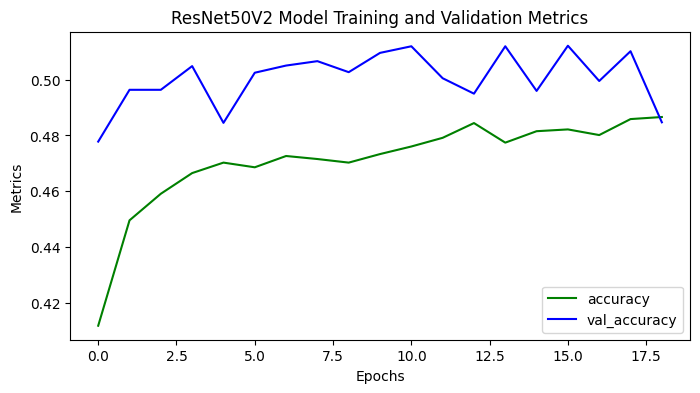

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['red', 'green', 'magenta', 'blue']
keys = list(history_resnet_model.history.keys())

for i, key in enumerate(keys):
    if i in (1,3):
        ax.plot(history_resnet_model.history[key], color=colors[i], label=key)

ax.set_xlabel('Epochs')
ax.set_ylabel('Metrics')
ax.set_title('ResNet50V2 Model Training and Validation Metrics')
ax.legend()

# ax.set_ylim([0, 1])
plt.show()

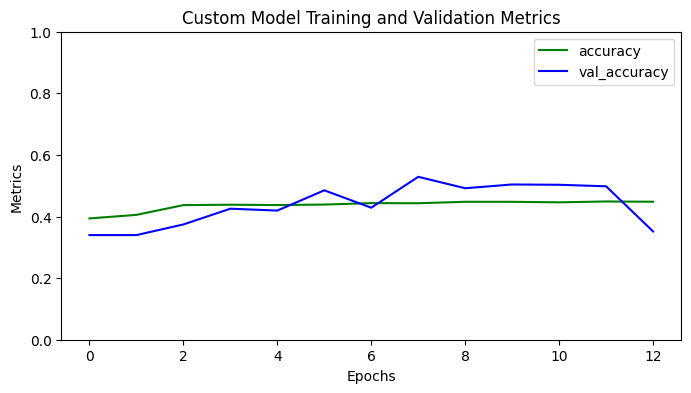

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['red', 'green', 'magenta', 'blue']
keys = list(history_custom_model.history.keys())

for i, key in enumerate(keys):
    if i in (1,3):
        ax.plot(history_custom_model.history[key], color=colors[i], label=key)

ax.set_xlabel('Epochs')
ax.set_ylabel('Metrics')
ax.set_title('Custom Model Training and Validation Metrics')
ax.legend()

ax.set_ylim([0, 1])  # Set the limits of the y-axis

plt.show()

In [34]:
with strategy.scope():

    # Load MobileNetV2 with grayscale input
    mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    mobilenet_base.trainable = False

    # Unfreeze the top layers of the model
    for layer in mobilenet_base.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # Check the trainable status of the individual layers
    for layer in mobilenet_base.layers:
        print(layer.name, layer.trainable)

input_2 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [35]:
with strategy.scope():
    # Build the model
    mobilenet_model = Sequential([
        mobilenet_base,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(NUMCLASSES, activation='softmax')  # 3 classes
    ])

    # Compile the model
    mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [36]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path_mobilenet = "best_mobilenet_model.h5"
mobilenet_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_mobilenet,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [37]:
NUM_EPOCHS = 25 # Adjust this number based on your observations during training

# Train the model with the callbacks
with strategy.scope():

    mobilenet_history = mobilenet_model.fit(
        train_dataset_one_hot,
        validation_data=val_dataset_one_hot,
        epochs=NUM_EPOCHS,
        callbacks=[reduce_lr, early_stopping, mobilenet_checkpoint_callback]
    )

Epoch 1/25
317/317 [==============================] - ETA: 0s - loss: 1.7282 - accuracy: 0.4783
Epoch 1: val_accuracy improved from -inf to 0.52479, saving model to best_mobilenet_model.h5
317/317 [==============================] - 54s 144ms/step - loss: 1.7282 - accuracy: 0.4783 - val_loss: 1.0660 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 2/25
316/317 [============================>.] - ETA: 0s - loss: 1.0476 - accuracy: 0.5065
Epoch 2: val_accuracy did not improve from 0.52479
317/317 [==============================] - 41s 130ms/step - loss: 1.0475 - accuracy: 0.5065 - val_loss: 0.9709 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 3/25
316/317 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5072
Epoch 3: val_accuracy did not improve from 0.52479
317/317 [==============================] - 41s 131ms/step - loss: 0.9951 - accuracy: 0.5071 - val_loss: 0.9645 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 4/25
316/317 [============================>.] - ETA: 0s - loss: 0.9897

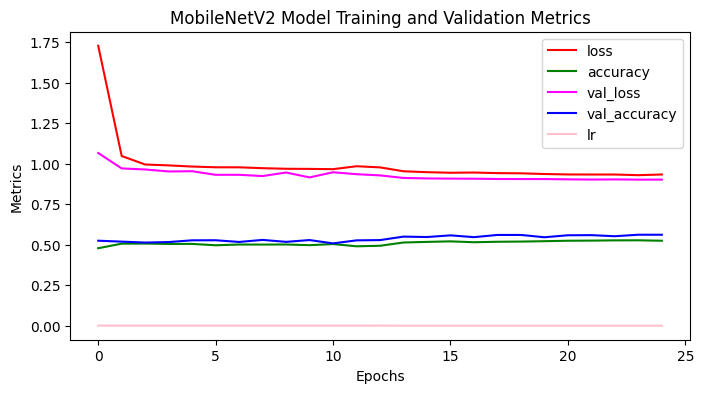

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['red', 'green', 'magenta', 'blue', 'pink']
keys = list(mobilenet_history.history.keys())

for i, key in enumerate(keys):
#     if i in (1,3):
        ax.plot(mobilenet_history.history[key], color=colors[i], label=key)

ax.set_xlabel('Epochs')
ax.set_ylabel('Metrics')
ax.set_title('MobileNetV2 Model Training and Validation Metrics')
ax.legend()

# ax.set_ylim([0, 1])
plt.show()

## Note on Model Training

It was observed that, in certain instances, the validation accuracy (`val_acc`) exceeded the training accuracy (`acc`). This uncommon occurrence may be attributed to various factors affecting the model's performance on the training and validation datasets.

Further investigation and analysis are recommended to better understand the dynamics contributing to this phenomenon. The unexpected relationship between training and validation accuracies prompts consideration for potential insights into model generalization and performance nuances.

In [39]:
del train_dataset_one_hot
del val_dataset_one_hot

In [40]:
# Load the best-performing models
best_resnet_model = load_model("best_resnet_model.h5")
best_custom_model = load_model("best_custom_model.h5")
best_mobilenet_model = load_model("best_mobilenet_model.h5")

# Preprocess the test dataset
test_dataset_one_hot = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels_one_hot))
test_dataset_one_hot = test_dataset_one_hot.map(preprocess_image, num_parallel_calls=n_p_c)
test_dataset_one_hot = test_dataset_one_hot.cache().batch(BATCH_SIZE).prefetch(n_p_c)

# Evaluate the models on the test dataset
resnet_predictions = best_resnet_model.predict(test_dataset_one_hot)
custom_predictions = best_custom_model.predict(test_dataset_one_hot)
mobilenet_predictions = best_mobilenet_model.predict(test_dataset_one_hot)

# Convert predictions to class labels
resnet_predicted_labels = np.argmax(resnet_predictions, axis=1)
custom_predicted_labels = np.argmax(custom_predictions, axis=1)
mobilenet_predicted_labels = np.argmax(mobilenet_predictions, axis=1)

# Convert true labels to class labels
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Create classification reports
resnet_classification_report = classification_report(true_labels, resnet_predicted_labels)
custom_classification_report = classification_report(true_labels, custom_predicted_labels)
mobilenet_classification_report = classification_report(true_labels, mobilenet_predicted_labels)

# Display classification reports
print("ResNet50V2 Classification Report:")
print(resnet_classification_report)

print("\nCustom Model Classification Report:")
print(custom_classification_report)

print("\nMobileNetV2 Classification Report:")
print(mobilenet_classification_report)


220/220 [==============================] - 26s 109ms/step
ResNet50V2 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      4691
           1       0.37      0.28      0.32      4692
           2       0.46      0.59      0.52      4691

    accuracy                           0.51     14074
   macro avg       0.51      0.51      0.50     14074
weighted avg       0.51      0.51      0.50     14074


Custom Model Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.92      0.71      4691
           1       0.43      0.15      0.22      4692
           2       0.48      0.51      0.49      4691

    accuracy                           0.53     14074
   macro avg       0.50      0.53      0.48     14074
weighted avg       0.50      0.53      0.48     14074


MobileNetV2 Classification Report:
              precision    recall  f1-score   support

           0      

Among the three models, MobileNetV2 appears to have the best overall performance based on the provided metrics.
However, it's important to note that the models struggle with certain classes, especially Class 1 (TTbar), indicating potential areas for improvement or further exploration.

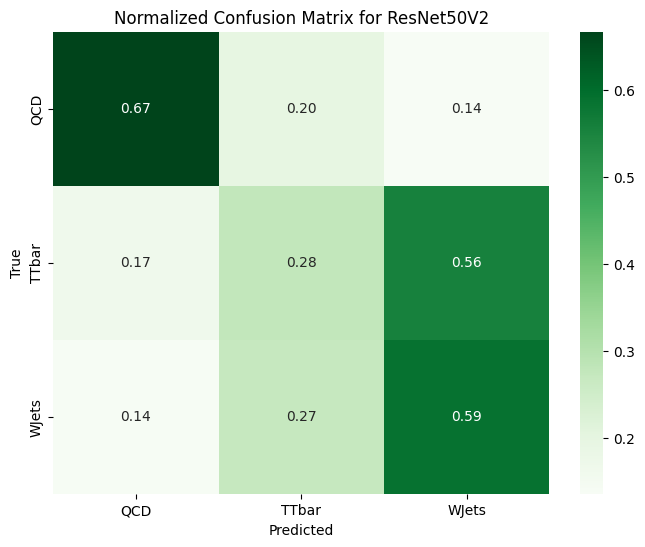

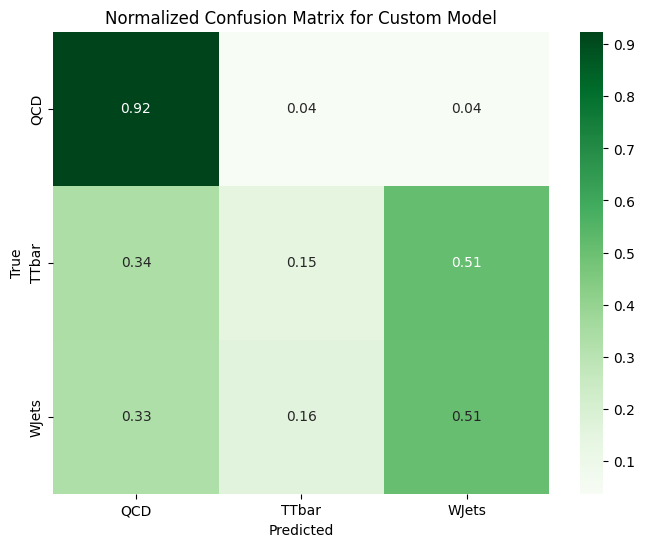

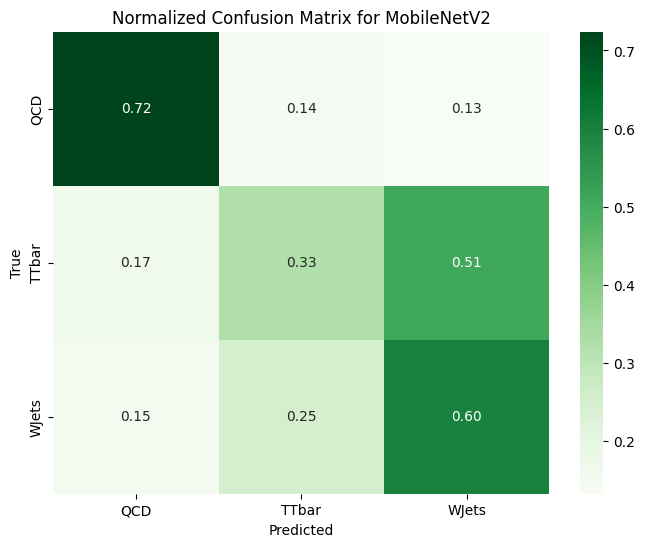

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot normalized confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names, model_name):
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.show()

# Create confusion matrices
plot_confusion_matrix(true_labels, resnet_predicted_labels, class_names=['QCD', 'TTbar', 'WJets'], model_name='ResNet50V2')
plot_confusion_matrix(true_labels, custom_predicted_labels, class_names=['QCD', 'TTbar', 'WJets'], model_name='Custom Model')
plot_confusion_matrix(true_labels, mobilenet_predicted_labels, class_names=['QCD', 'TTbar', 'WJets'], model_name='MobileNetV2')


## Conclusion

In this project, we delved into the realm of neural networks, specifically exploring the efficacy of Convolutional Neural Networks (CNNs) in classifying images from particle physics collisions. Our investigation involved training three distinct models—ResNet50V2, a custom-designed architecture, and MobileNetV2—on a dataset encompassing Quantum Chromodynamics (QCD), Top-Antitop Pair Production (TTbar), and W Bosons in association with jets (WJets).

### Key Insights:
- The models showcased notable advancements in accuracy when compared to our initial foray with SVM and Random Forest, achieving comparable scores (ResNet50V2: 0.51, Custom Model: 0.53, MobileNetV2: 0.55).
- Confusion matrices unearthed specific challenges in discerning between QCD and WJets classes, underscoring potential avenues for model refinement.
- Leveraging transfer learning with pre-trained models (ResNet50V2, MobileNetV2) proved instrumental in extracting discriminative features for effective classification.

### Limitations and Hurdles:
- A significant constraint in our project lies in the dataset's quality. Characterized by low resolution and weak image quality, these limitations impede the models' ability to extract nuanced features critical for accurate classification.
- The downsizing of images introduces a trade-off, potentially leading to information loss that hampers the models' capability to capture subtle patterns and intricacies within the data.

### Future Trajectories:
- Future endeavors should focus on meticulous fine-tuning and optimization to elevate the models' classification performance.
- Exploring additional preprocessing techniques and incorporating data augmentation strategies holds promise in enhancing the models' generalization abilities.
- Mitigating the dataset's limitations, whether by acquiring higher-quality images or exploring alternative datasets, is pivotal for cultivating more robust and accurate models.

The project, while providing valuable insights, candidly acknowledges the challenges posed by the dataset's inherent limitations. Subsequent research pursuits should actively address these challenges to yield more dependable and impactful outcomes.


## Bonus

In [ ]:
# Testing
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import matplotlib.cm as cm

# Function to generate class activation heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients of the top predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, np.argmax(preds[0])]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display images with superimposed heatmap
def display_images_with_heatmap(images, model, last_conv_layer_name, classifier_layer_names, num_images=9):
    fig = plt.figure(figsize=(12, 18))
    for i in range(min(num_images, images.shape[0])):
        ax = fig.add_subplot(3, 3, i + 1)
        img = images[i, :]
        img_array = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

        preds = model.predict(img_array, steps=1)

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

        # We rescale heatmap to a range 0-255
        heatmap = (heatmap * 255).astype(np.uint8)

        # Apply colormap
        jet = cm.get_cmap("jet")
        jet_colors = jet(heatmap)
        jet_heatmap = jet_colors[:, :, :3]

        # Superimpose the heatmap on the original image
        superimposed_img = (img * 255).astype(np.uint8)
        superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_GRAY2RGB)
        superimposed_img = cv2.addWeighted(jet_heatmap, 0.7, superimposed_img, 0.3, 0)

        ax.imshow(superimposed_img)
        ax.set_title(f"Predicted: {np.argmax(preds)}")
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Display images with superimposed heatmap
display_images_with_heatmap(testdigits, model, last_conv_layer_name, classifier_layer_names, num_images=9)


In [41]:
# Process each image in the list
# processed_images_list = [preprocess_image(filepath, label) for filepath, label in zip(test_filepaths, test_labels_one_hot)]

In [42]:
# np.array(processed_images_list).shape

In [43]:
# processed_images2 = []
# labels2 = []

# for filepath, label in zip(test_filepaths, test_labels_one_hot):
#     processed_image = preprocess_image(filepath, label)
#     processed_images.append(processed_image[0].numpy())

# processed_images = np.array(processed_images)

In [44]:
# Extract images and labels from the processed list
# processed_images = np.array([img[0].numpy() for img in processed_images_list])
# labels = np.array([img[1] for img in processed_images_list])

In [45]:
# test_iterator = iter(test_dataset_one_hot)
# testing_images, testing_labels = next(test_iterator)

In [46]:
# np.sum(test_iterator)

In [47]:
# # Get predictions from both models
# predictions_resnet = resnet_model.predict(testing_images, steps=1, verbose=0)
# predictions_custom = custom_model.predict(testing_images, steps=1, verbose=0)

# # Convert predictions to class indices
# predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)
# predicted_classes_custom = np.argmax(predictions_custom, axis=1)

# # Convert one-hot encoded true labels to class indices
# true_classes = np.argmax(testing_labels, axis=1)

# # Class labels (replace 'class_labels' with your actual class names)
# class_labels = ['QCD', 'TTbar', 'WJets']  # Adjust this based on your dataset

# # Generate the classification report for model1
# report_resnet = classification_report(true_classes, predicted_classes_resnet, target_names=class_labels)
# # Generate the classification report for custom_model
# report_custom = classification_report(true_classes, predicted_classes_custom, target_names=class_labels)

# # Print the classification reports
# print("Classification Report for Model 1:")
# print(report_resnet)
# print("\nClassification Report for Custom Model:")
# print(report_custom)

In [48]:
# testing_labels

In [49]:
# # Fit the model
# history = model.fit(
#     train_dataset_one_hot,
#     validation_data=val_dataset_one_hot,
#     epochs=10,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         )
#     ]
# )

In [50]:
# with strategy.scope():
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(256, (3, 3), activation='relu'),  # New convolutional layer
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(256, activation='relu'),
#         Dropout(0.5),
#         Dense(128, activation='relu'),  # Additional dense layer
#         Dropout(0.5),
#         Dense(3, activation='softmax')
#     ])

#     model.compile(optimizer='adam', 
#                   loss="categorical_crossentropy", 
#                   metrics=['accuracy'])

# # Model summary
# model.summary()

# # Fit the model
# history = model.fit(
#     train_dataset_one_hot,
#     validation_data=val_dataset_one_hot,
#     epochs=10,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         )
#     ]
# )